In [11]:
import pypsa
import numpy as np
from grg_pssedata.io import parse_psse_case_file

In [12]:
def verify_generators(network: pypsa.Network, case, tol: float = 1e-6):
    """
    Verify that all in‐service generators in the parsed PSS/E case
    have been added correctly to the PyPSA network.
    Only checks attributes sourced directly from the RAW file.
    """
    from collections import defaultdict

    # 1) Build PSS/E → PyPSA name mapping for in‐service gens
    ide_to_ctrl = {1: "PQ", 2: "PV", 3: "Slack"}
    bus_map = {b.i: b for b in case.buses}

    in_service = [g for g in case.generators if g.stat == 1]
    psse_names = [f"{g.i}-{g.id.strip()}" for g in in_service]
    psa_names  = list(network.generators.index)

    # counts
    assert len(psse_names) == len(psa_names), (
        f"Generator count mismatch: RAW={len(psse_names)} vs PyPSA={len(psa_names)}"
    )

    # 2) Check each generator one by one
    for g in in_service:
        name = f"{g.i}-{g.id.strip()}"
        assert name in network.generators.index, f"Missing generator {name}"

        ng = network.generators.loc[name]
        psse_bus = str(g.i)

        # bus
        assert ng.bus == psse_bus, (
            f"{name}: bus mismatch RAW={psse_bus} vs PyPSA={ng.bus}"
        )

        # control mode derived from bus.ide
        expected_ctrl = ide_to_ctrl.get(bus_map[g.i].ide, "PQ")
        assert ng.control == expected_ctrl, (
            f"{name}: control mismatch RAW={expected_ctrl} vs PyPSA={ng.control}"
        )

        # active/reactive setpoints
        np.testing.assert_allclose(ng.p_set, g.pg, atol=tol,
            err_msg=f"{name}: p_set mismatch RAW={g.pg} vs PyPSA={ng.p_set}")
        np.testing.assert_allclose(ng.q_set, g.qg, atol=tol,
            err_msg=f"{name}: q_set mismatch RAW={g.qg} vs PyPSA={ng.q_set}")

        # nominal power
        np.testing.assert_allclose(ng.p_nom, g.pt, atol=tol,
            err_msg=f"{name}: p_nom mismatch RAW={g.pt} vs PyPSA={ng.p_nom}")

        # per‐unit min dispatch
        expected_min_pu = (g.pb / g.pt) if g.pt else 0.0
        np.testing.assert_allclose(ng.p_min_pu, expected_min_pu, atol=tol,
            err_msg=f"{name}: p_min_pu mismatch RAW={expected_min_pu} vs PyPSA={ng.p_min_pu}")

        # per‐unit max dispatch (should default to 1.0)
        np.testing.assert_allclose(ng.p_max_pu, 1.0, atol=tol,
            err_msg=f"{name}: p_max_pu expected 1.0, got {ng.p_max_pu}")

    print(f"✅ All {len([g for g in case.generators if g.stat==1])} in-service Generator verified successfully.")

In [13]:

def verify_buses(network: pypsa.Network,
                      case,
                      tol: float = 1e-6):
    """
    Verifies that all buses from the parsed PSS/E case
    have been added correctly to the PyPSA network.
    Checks:
      - count
      - name
      - v_nom [kV]
      - v_mag_pu_set, v_mag_pu_min, v_mag_pu_max
      - control mode
    """
    # 1) quick counts
    raw_n = len(case.buses)
    psa_n = len(network.buses)
    assert raw_n == psa_n, f"Bus count mismatch RAW={raw_n} vs PyPSA={psa_n}"

    # 2) build lookup of raw buses
    bus_map = {b.name.strip(): b for b in case.buses}

    # 3) expected control mapping
    ide_to_ctrl = {1: "PQ", 2: "PV", 3: "Slack"}

    for name in network.buses.index:
        assert name in bus_map, f"Bus {name} present in PyPSA but not in RAW"
        raw = bus_map[name]
        pb  = network.buses.loc[name]

        # v_nom
        assert abs(pb.v_nom - raw.basekv) < tol, (
            f"{name}: v_nom mismatch RAW={raw.basekv} vs PyPSA={pb.v_nom}"
        )
        # per‐unit set/min/max
        assert abs(pb.v_mag_pu_set - raw.vm) < tol, (
            f"{name}: v_mag_pu_set RAW={raw.vm} vs PyPSA={pb.v_mag_pu_set}"
        )
        assert abs(pb.v_mag_pu_min - raw.nvlo) < tol, (
            f"{name}: v_mag_pu_min RAW={raw.nvlo} vs PyPSA={pb.v_mag_pu_min}"
        )
        assert abs(pb.v_mag_pu_max - raw.nvhi) < tol, (
            f"{name}: v_mag_pu_max RAW={raw.nvhi} vs PyPSA={pb.v_mag_pu_max}"
        )
        # control
        expected_ctrl = ide_to_ctrl.get(raw.ide, "PQ")
        assert pb.control == expected_ctrl, (
            f"{name}: control mismatch RAW={expected_ctrl} vs PyPSA={pb.control}"
        )

    print(f"✅ All {raw_n} buses verified successfully.")

In [14]:
import numpy as np

def verify_lines(network: pypsa.Network, case, tol: float = 1e-6):
    """
    Verify that each in-service PSS/E Branch (case.branches)
    was added as a pyPSA Line with matching attributes.
    """
    lines = network.lines

    for br in case.branches:
        if br.st != 1:
            continue

        lname = f"{br.i}-{br.j}-{br.ckt}".replace(" ", "")
        assert lname in lines.index, f"Line {lname!r} missing from network.lines"
        ln = lines.loc[lname]

        # ─── required inputs ────────────────────────────────────────────────────
        assert ln.bus0 == str(br.i),           f"{lname}: bus0 mismatch RAW={br.i} vs PSA={ln.bus0}"
        assert ln.bus1 == str(br.j),           f"{lname}: bus1 mismatch RAW={br.j} vs PSA={ln.bus1}"
        assert ln.type == "",                  f"{lname}: expected blank type"

        # impedance & shunts (all in pu on system base)
        for attr in ("r", "x"):
            raw = getattr(br, attr)
            psa = getattr(ln, attr)
            assert np.isclose(psa, raw, atol=tol), (
                f"{lname}: {attr} mismatch RAW={raw} vs PSA={psa}"
            )

        raw_g = br.gi + br.gj
        raw_b = br.bi + br.bj
        assert np.isclose(ln.g, raw_g, atol=tol),   f"{lname}: g mismatch RAW={raw_g} vs PSA={ln.g}"
        assert np.isclose(ln.b, raw_b, atol=tol),   f"{lname}: b mismatch RAW={raw_b} vs PSA={ln.b}"

        # thermal rating level 1 → s_nom
        assert np.isclose(ln.s_nom, br.ratea, atol=tol), (
            f"{lname}: s_nom mismatch RAW={br.ratea} vs PSA={ln.s_nom}"
        )

        # ─── locked-in & limits ─────────────────────────────────────────────────
        assert ln.s_nom_extendable == False, f"{lname}: expected s_nom_extendable=False"
        assert np.isclose(ln.s_nom_min, 0.0, tol), f"{lname}: expected s_nom_min=0"
        assert np.isclose(ln.s_nom_max, br.ratea, tol), (
            f"{lname}: s_nom_max mismatch RAW={br.ratea} vs PSA={ln.s_nom_max}"
        )
        assert np.isclose(ln.s_max_pu, 1.0, tol),   f"{lname}: expected s_max_pu=1.0"

        # ─── common optional inputs ─────────────────────────────────────────────
        assert np.isclose(ln.capital_cost, 0.0, tol),    f"{lname}: expected capital_cost=0"
        assert ln.build_year == 0,                      f"{lname}: expected build_year=0"
        assert ln.lifetime == np.inf,                   f"{lname}: expected lifetime=inf"
        assert np.isclose(ln.length, br.len, tol),      f"{lname}: length mismatch RAW={br.len} vs PSA={ln.length}"
        assert ln.carrier == "AC",                      f"{lname}: expected carrier='AC'"
        assert np.isclose(ln.terrain_factor, 1.0, tol),  f"{lname}: expected terrain_factor=1.0"
        assert np.isclose(ln.num_parallel, 1.0, tol),    f"{lname}: expected num_parallel=1.0"
        assert ln.v_ang_min == -np.inf,                 f"{lname}: expected v_ang_min=-inf"
        assert ln.v_ang_max ==  np.inf,                 f"{lname}: expected v_ang_max=inf"

    print(f"✅ All {len([b for b in case.branches if b.st==1])} in-service branches verified successfully.")

In [15]:
import numpy as np
import pypsa

def verify_transformers(network: pypsa.Network, case, tol: float = 1e-6):
    """
    Verify that every Two‐WindingTransformer in case.transformers
    was added as a PyPSA Transformer with matching buses, pu‐impedance,
    rating, tap settings and defaults.
    """
    tx_df = network.transformers

    for tx in case.transformers:
        # unpack raw data
        p1, p2, w1, w2 = tx.p1, tx.p2, tx.w1, tx.w2
        # name used when importing
        name = f"{p1.i}-{p1.j}-{p1.ckt}".strip()
        assert name in tx_df.index, f"Transformer {name!r} missing from network.transformers"
        psa = tx_df.loc[name]

        # ─── buses ───────────────────────────────────────────────────────────────────
        assert psa.bus0 == str(p1.i), f"{name}: bus0 {psa.bus0!r} ≠ RAW {p1.i}"
        assert psa.bus1 == str(p1.j), f"{name}: bus1 {psa.bus1!r} ≠ RAW {p1.j}"

        # ─── model ───────────────────────────────────────────────────────────────────
        assert psa.model == "t", f"{name}: model {psa.model!r} ≠ 't'"

        # ─── series impedance (pu on case.sbase) ────────────────────────────────────
        raw_rpu = p2.r12 * (p2.sbase12 / case.sbase)
        raw_xpu = p2.x12 * (p2.sbase12 / case.sbase)
        assert np.isclose(psa.r, raw_rpu, atol=tol), f"{name}: r {psa.r} ≠ RAW {raw_rpu}"
        assert np.isclose(psa.x, raw_xpu, atol=tol), f"{name}: x {psa.x} ≠ RAW {raw_xpu}"

        # ─── rating & locking ─────────────────────────────────────────────────────────
        # we imported w1.rata as both s_nom and s_nom_max, with s_nom_extendable=False
        assert np.isclose(psa.s_nom, w1.rata, atol=tol), \
            f"{name}: s_nom {psa.s_nom} ≠ RAW rata {w1.rata}"
        assert psa.s_nom_extendable == False, \
            f"{name}: s_nom_extendable {psa.s_nom_extendable} ≠ False"
        assert np.isclose(psa.s_nom_max, w1.rata, atol=tol), \
            f"{name}: s_nom_max {psa.s_nom_max} ≠ RAW rata {w1.rata}"

        # ─── tap & phase ──────────────────────────────────────────────────────────────
        assert np.isclose(psa.tap_ratio, w1.windv, atol=tol), \
            f"{name}: tap_ratio {psa.tap_ratio} ≠ RAW windv {w1.windv}"
        assert psa.tap_side == 0, f"{name}: tap_side {psa.tap_side} ≠ imported side=0"
        assert np.isclose(psa.phase_shift, w1.ang, atol=tol), \
            f"{name}: phase_shift {psa.phase_shift} ≠ RAW ang {w1.ang}"

        # ─── common defaults ───────────────────────────────────────────────────────────
        assert np.isclose(psa.capital_cost, 0.0, atol=tol), \
            f"{name}: capital_cost {psa.capital_cost} ≠ 0.0"
        assert np.isclose(psa.num_parallel, 1.0, atol=tol), \
            f"{name}: num_parallel {psa.num_parallel} ≠ 1.0"
        assert np.isclose(psa.g, p1.mag1 * (1/case.sbase), atol=tol)
            #f"{name}: g {psa.g} ≠ RAW {p1.mag1 * (1/case.sbase)}"
        assert np.isclose(psa.b, p1.mag2 * (1/case.sbase), atol=tol)
            #f"{name}: b {psa.b} ≠ RAW {p1.mag2 * (1/case.sbase)}"
    print(f"✅ All {len(case.transformers)} two‐winding transformers verified successfully.")

In [16]:
import numpy as np

def verify_loads(network: pypsa.Network, case, tol: float = 1e-6):
    """
    Verify that each in-service PSS/E Load (case.loads)
    was added as a pyPSA Load with matching attributes.
    """
    loads = network.loads

    for L in case.loads:
        # skip out-of-service loads
        if L.status != 1:
            continue

        # name we used when adding
        lname = f"{L.i}-load{L.id.strip()}".replace(" ", "")
        assert lname in loads.index, f"Load {lname!r} missing from network.loads"

        ln = loads.loc[lname]

        # bus assignment
        assert ln.bus == str(L.i), (
            f"{lname}: bus mismatch RAW={L.i} vs PSA={ln.bus}"
        )

        # active and reactive power consumption
        assert np.isclose(ln.p_set, L.pl, atol=tol), (
            f"{lname}: p_set mismatch RAW={L.pl} vs PSA={ln.p_set}"
        )
        assert np.isclose(ln.q_set, L.ql, atol=tol), (
            f"{lname}: q_set mismatch RAW={L.ql} vs PSA={ln.q_set}"
        )

        # carrier and sign
        assert ln.carrier == "AC", (
            f"{lname}: carrier mismatch RAW='AC' vs PSA={ln.carrier}"
        )
        assert ln.sign == -1.0, (
            f"{lname}: sign mismatch RAW=-1 vs PSA={ln.sign}"
        )

    print(f"✅ All {len([L for L in case.loads if L.status==1])} in-service loads verified successfully.")

In [17]:
import numpy as np

def verify_switched_shunts(network: pypsa.Network, case, tol: float = 1e-8):
    """
    Verify that each in‐service PSS/E SwitchedShunt ended up
    as exactly one ShuntImpedance on its bus, with the correct
    susceptance in Siemens (S).
    """
    si = network.shunt_impedances
    checked = 0

    for ss in case.switched_shunts:
        if ss.stat != 1:
            continue
        checked += 1
        bus = str(ss.i)

        # find the one ShuntImpedance on this bus
        matches = si.index[si.bus == bus].tolist()
        assert len(matches) == 1, (
            f"Bus {bus}: expected 1 switched-shunt, found {len(matches)}"
        )
        psa = si.loc[matches[0]]

        # ── convert RAW binit [MVAr @ 1 pu] → Siemens ────────────────
        # network.buses.v_nom is in kV → convert to V
        V_nom = network.buses.at[bus, "v_nom"] * 1e3
        # RAW binit is MVAr at 1 pu → Q = binit×1e6 VAR
        # susceptance b [S] = Q / V²
        expected_b = ss.binit * 1e6 / (V_nom**2)
        assert np.isclose(psa.b, expected_b, atol=tol), (
            f"Bus {bus}: b {psa.b:.6e} S ≠ expected {expected_b:.6e} S"
        )

        # no real conductance
        assert psa.g == 0.0, f"Bus {bus}: g {psa.g} ≠ 0.0"

        # sign convention
        assert psa.sign == -1.0, f"Bus {bus}: sign {psa.sign} ≠ -1.0"

    print(f"✅ All {checked} in‐service switched-shunts verified successfully.")

In [18]:
import numpy as np

def verify_bus_mapping(network, case, tol=1e-8):
    ide_to_ctrl = {1:"PQ", 2:"PV", 3:"Slack"}
    for b in case.buses:
        key = str(b.i)
        assert key in network.buses.index, f"Bus {b.i} missing"
        p = network.buses.loc[key]
        # Base voltage [kV]
        assert np.isclose(p.v_nom, b.basekv, atol=tol)
        # pu‐set & limits
        for attr, val in [
            ("v_mag_pu_set", b.vm),
            ("v_mag_pu_min", b.nvlo),
            ("v_mag_pu_max", b.nvhi),
        ]:
            assert np.isclose(getattr(p, attr), val, atol=tol)
        # control mode
        assert p.control == ide_to_ctrl[b.ide]
    print(f"✅ {len(case.buses)} buses OK")

In [112]:
import pypsa
from grg_pssedata.io import parse_psse_case_file

def import_raw_to_pypsa(case_file):
    """
    Builds a PyPSA Network from a parsed PSS/E RAW case file.
    Only sets necessary fields for a valid power flow.
    """
    case = parse_psse_case_file(case_file)
    network = pypsa.Network(s_n_mva=case.sbase)  # System base MVA
    
    case.bus_lookup = {bus.i: bus for bus in case.buses}

    # Mapping PSS/E bus types to PyPSA control types
    ide_to_ctrl = {1: "PQ", 2: "PV", 3: "Slack"}

    # --- Add Buses ---
    for bus in case.buses:
        network.add("Bus",
            name          = str(bus.i),
            v_nom         = bus.basekv,        # [kV]
            v_mag_pu_set  = bus.vm,             # [pu]
            v_mag_pu_min  = bus.nvlo,           # [pu]
            v_mag_pu_max  = bus.nvhi,           # [pu]
            control       = ide_to_ctrl.get(bus.ide, "PQ"),
        )

    # --- Add Lines (Branches) ---
    for idx, br in enumerate(case.branches):
        lname = f"L{idx}"
        V_bus_kV = network.buses.at[str(br.i), "v_nom"]
        V_bus_V = V_bus_kV * 1e3  # Convert to [V]
        S_base_VA = case.sbase * 1e6
        Z_base = V_bus_V**2 / S_base_VA

        network.add("Line",
            name         = lname,
            bus0         = str(br.i),
            bus1         = str(br.j),
            r            = br.r * Z_base,  # [Ohm]
            x            = br.x * Z_base,  # [Ohm]
            s_nom        = br.ratea,        # [MVA]
            s_nom_extendable = False,
        )

    # --- Add Transformers ---
    for idx, tx in enumerate(case.transformers):
        tname = f"T{idx}"
        s_nom = tx.w1.rata  # Base rating on winding 1 [MVA]

        r_pu = tx.p2.r12 * (tx.p2.sbase12 / s_nom)
        x_pu = tx.p2.x12 * (tx.p2.sbase12 / s_nom)

        network.add("Transformer",
            name          = tname,
            bus0          = str(tx.p1.i),
            bus1          = str(tx.p1.j),
            r             = r_pu,      # [pu on s_nom]
            x             = x_pu,      # [pu on s_nom]
            s_nom         = s_nom,     # [MVA]
            tap_ratio     = tx.w1.windv,  # Tap [pu]
            phase_shift   = tx.w1.ang,     # [deg]
            s_nom_extendable = False,
        )

    # --- Add Generators ---
    for idx, g in enumerate(case.generators):
        if g.stat != 1:
            continue

        gname = f"G{idx}"
        ctrl = ide_to_ctrl.get(case.bus_lookup[g.i].ide, "PQ")

        network.add("Generator",
            name       = gname,
            bus        = str(g.i),
            control    = ctrl,
            p_nom      = g.pt,
            p_set      = g.pg,
            q_set      = g.qg,
            p_min_pu   = (g.pb / g.pt) if g.pt else 0.0,
            p_max_pu   = 1.0,
        )

    # --- Add Loads ---
    for idx, load in enumerate(case.loads):
        if load.status != 1:
            continue

        lname = f"L{idx}"
        network.add("Load",
            name  = lname,
            bus   = str(load.i),
            p_set = load.pl,
            q_set = load.ql,
        )

    # --- Add Switched Shunts (as ShuntImpedance) ---
    for idx, ss in enumerate(case.switched_shunts):
        if ss.stat != 1:
            continue

        bus_name = str(ss.i)
        V_nom_kV = network.buses.at[bus_name, "v_nom"]
        V_nom_V = V_nom_kV * 1e3
        b_S = (ss.binit * 1e6) / V_nom_V**2  # Susceptance in Siemens

        network.add("ShuntImpedance",
            name = f"Sh{idx}",
            bus  = bus_name,
            b    = b_S,
        )

    # Optional: Solve and check initialization
    network.pf()

    return network, case



def add_wec(network, bus_name="WEC_Bus", p_nom=5.0, bus_voltage_kv=34.5, connect_to_bus="1", line_r_pu=0.01, line_x_pu=0.05):
    """
    Add a simple WEC (Wave Energy Converter) to a PyPSA network.

    Args:
        network (pypsa.Network): Existing PyPSA network
        bus_name (str): Name for the new WEC bus
        p_nom (float): WEC rated capacity [MW]
        bus_voltage_kv (float): Nominal voltage at WEC bus [kV]
        connect_to_bus (str): Bus to connect WEC to
        line_r_pu (float): Per-unit resistance
        line_x_pu (float): Per-unit reactance
    """

    # 1. Add WEC bus
    network.add("Bus",
        name = bus_name,
        v_nom = bus_voltage_kv,
        carrier = "AC",
    )

    # 2. Add WEC generator
    network.add("Generator",
        name = "WEC_Gen",
        bus = bus_name,
        carrier = "wave",
        p_nom = p_nom,
        p_set = p_nom * 0.5,  # Start half-loaded
        marginal_cost = 0.0,
        control = "PQ",
        efficiency = 1.0,
    )

    # 3. Add connecting line
    V_nom_V = network.buses.at[connect_to_bus, "v_nom"] * 1e3
    S_base_VA = network.s_n_mva * 1e6  # <-- use network.s_n_mva here
    Z_base = V_nom_V**2 / S_base_VA

    network.add("Line",
        name = "WEC_Line",
        bus0 = bus_name,
        bus1 = connect_to_bus,
        r = line_r_pu * Z_base,
        x = line_x_pu * Z_base,
        s_nom = p_nom,
    )

    print(f"✅ Added WEC: {p_nom} MW at bus '{connect_to_bus}'.")

# Usage
case_file = "../WecGrid/models/grid_models/IEEE_24_bus.RAW"
network, case = import_raw_to_pypsa(case_file)

add_wec(
    network,
    bus_name="WEC_Bus",
    p_nom=0.025,  # 25 kW nominal power (realistic)
    bus_voltage_kv=13.8,  # reasonable medium voltage
    connect_to_bus="7",   # or wherever
    line_r_pu=0.01,
    line_x_pu=0.05,
)

network.pf()

case data: 0     100.00  33  0  0  60.00       
record 1: 
record 2: 
parsed 24 buses
parsed 16 loads
parsed 0 fixed shunts
parsed 11 generators
parsed 32 branches
parsed 6 transformers
parsed 1 areas
parsed 0 two terminal dc lines
parsed 0 vsc dc lines
parsed 0 transformer corrections
parsed 0 multi-terminal dc lines
parsed 0 multi-section lines
parsed 1 zones
parsed 0 inter-area transfers
parsed 1 owners
parsed 0 facts devices
parsed 2 switched shunts
parsed 0 induction machines
un-parsed lines:
  Q

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.037986 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')


✅ Added WEC: 0.025 MW at bus '7'.


INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.046000 seconds


{'n_iter': SubNetwork  0
 snapshot     
 now         4,
 'error': SubNetwork             0
 snapshot                
 now         1.951024e-07,
 'converged': SubNetwork     0
 snapshot        
 now         True}

In [114]:
network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
G0,1,Slack,,1000.000,False,0.0,inf,0.0,1.0,35.8490,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G1,2,PV,,1000.000,False,0.0,inf,0.0,1.0,67.0000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G2,7,PV,,1000.000,False,0.0,inf,0.0,1.0,64.0000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G3,13,PV,,1000.000,False,0.0,inf,0.0,1.0,200.0000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G4,14,PV,,1000.000,False,0.0,inf,0.0,1.0,0.0000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G5,15,PV,,1000.000,False,0.0,inf,0.0,1.0,274.0000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G6,16,PV,,1000.000,False,0.0,inf,0.0,1.0,245.0000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G7,18,PV,,1000.000,False,0.0,inf,0.0,1.0,144.0000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G8,21,PV,,1000.000,False,0.0,inf,0.0,1.0,294.0000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [ ]:
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import numpy as np
import pandas as pd

import sqlite3
import pandas as pd

def fetch_wec_data_from_db():
    # 1. Connect to your WEC-Grid database
    db_path = "../WecGrid/database_handler/WEC-GRID.db"
    conn = sqlite3.connect(db_path)

    # 2. Check available tables (optional, but nice to verify)
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

    # 3. Pull the WEC simulation output (example table: WEC_output_60)
    query = "SELECT * FROM WEC_output_60"
    wec_data = pd.read_sql_query(query, conn)

    conn.close()
    return wec_data

# 1. Setup time series
timestamp_start = datetime.now()
num_timesteps = 144  # 12 hours with 5-min steps
snapshots = pd.date_range(
    start=timestamp_start + DateOffset(minutes=5),
    periods=num_timesteps,
    freq="5T",
)

# 2. Set the snapshots for the network
network.set_snapshots(snapshots)

# 3. Update loads with Gaussian peak + random noise
noise_level = 0.002
p_load_values = network.loads["p_set"]
time_index = np.linspace(-1, 1, num_timesteps)
bell_curve = np.exp(-4 * time_index**2)
load_profiles = {}

for load_id, base_load in p_load_values.items():
    if base_load == 0:
        load_profiles[load_id] = np.zeros(num_timesteps)
        continue

    curve = base_load * (1 + 0.05 * bell_curve)
    noise = np.random.normal(0, noise_level * base_load, num_timesteps)
    curve += noise
    curve[0] = base_load  # First value clean
    load_profiles[load_id] = curve

df_loads = pd.DataFrame(load_profiles, index=snapshots)


wave_data = fetch_wec_data_from_db()
# If your WEC generator is called "WEC_Gen" and bus is "WEC_Bus" from earlier:
wec_power_series = wec_data["pg"]

wec_power_series.index = network.snapshots

network.generators_t.p_set["WEC_Gen"] = wec_power_series
network.loads_t.p_set = df_loads

# 6. Solve power flow
network.pf()

print("✅ Loads and WEC updated + power flow solved.")

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2025-04-27 13:02:12.139862', '2025-04-27 13:07:12.139862',
               '2025-04-27 13:12:12.139862', '2025-04-27 13:17:12.139862',
               '2025-04-27 13:22:12.139862', '2025-04-27 13:27:12.139862',
               '2025-04-27 13:32:12.139862', '2025-04-27 13:37:12.139862',
               '2025-04-27 13:42:12.139862', '2025-04-27 13:47:12.139862',
               ...
               '2025-04-28 00:12:12.139862', '2025-04-28 00:17:12.139862',
               '2025-04-28 00:22:12.139862', '2025-04-28 00:27:12.139862',
               '2025-04-28 00:32:12.139862', '2025-04-28 00:37:12.139862',
               '2025-04-28 00:42:12.139862', '2025-04-28 00:47:12.139862',
               '2025-04-28 00:52:12.139862', '2025-04-28 00:57:12.139862'],
              dtype='datetime64[ns]', name='snapshot', length=144, freq='5T')
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with erro

✅ Loads and WEC updated + power flow solved.


In [ ]:
import sqlite3
import pandas as pd

def fetch_wec_data_from_db():
    # 1. Connect to your WEC-Grid database
    db_path = "../WecGrid/database_handler/WEC-GRID.db"
    conn = sqlite3.connect(db_path)

    # 2. Check available tables (optional, but nice to verify)
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

    # 3. Pull the WEC simulation output (example table: WEC_output_60)
    query = "SELECT * FROM WEC_output_60"
    wec_data = pd.read_sql_query(query, conn)

    conn.close()
    return wec_data

,time,ibus,pg,vs,pt,pb,qt,qb
0,0.0,1.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000
1,450.0,1.0,0.016780,1.1,0.016780,0.0,0.057599,-0.057599
2,750.0,1.0,0.016497,1.1,0.016497,0.0,0.057677,-0.057677
3,1050.0,1.0,0.016940,1.1,0.016940,0.0,0.057533,-0.057533
4,1350.0,1.0,0.017691,1.1,0.017691,0.0,0.057250,-0.057250
...,...,...,...,...,...,...,...,...
139,41850.0,1.0,0.015768,1.1,0.015768,0.0,0.057798,-0.057798
140,42150.0,1.0,0.022782,1.1,0.022782,0.0,0.055365,-0.055365
141,42450.0,1.0,0.015574,1.1,0.015574,0.0,0.057925,-0.057925
142,42750.0,1.0,0.014986,1.1,0.014986,0.0,0.058083,-0.058083


In [125]:
# If your WEC generator is called "WEC_Gen" and bus is "WEC_Bus" from earlier:
wec_power_series = wec_data["pg"]

# 2. Reindex to network snapshots
# Create a pandas Series indexed by network.snapshots
# Stretch/expand wec_data if needed (since it's only 144 points — perfect match)
wec_power_series.index = network.snapshots

# 3. Insert into the PyPSA generator time series
network.generators_t.p_set["WEC_Gen"] = wec_power_series

In [126]:
wec_power_series

snapshot
2025-04-27 13:02:12.139862    0.000000
2025-04-27 13:07:12.139862    0.016780
2025-04-27 13:12:12.139862    0.016497
2025-04-27 13:17:12.139862    0.016940
2025-04-27 13:22:12.139862    0.017691
                                ...   
2025-04-28 00:37:12.139862    0.015768
2025-04-28 00:42:12.139862    0.022782
2025-04-28 00:47:12.139862    0.015574
2025-04-28 00:52:12.139862    0.014986
2025-04-28 00:57:12.139862    0.019310
Freq: 5T, Name: pg, Length: 144, dtype: float64

In [116]:
df_wec

,WEC_Gen
2025-04-27 13:02:12.139862,0.012500
2025-04-27 13:07:12.139862,0.013049
2025-04-27 13:12:12.139862,0.013597
2025-04-27 13:17:12.139862,0.014143
2025-04-27 13:22:12.139862,0.014686
...,...
2025-04-28 00:37:12.139862,0.010314
2025-04-28 00:42:12.139862,0.010857
2025-04-28 00:47:12.139862,0.011403
2025-04-28 00:52:12.139862,0.011951


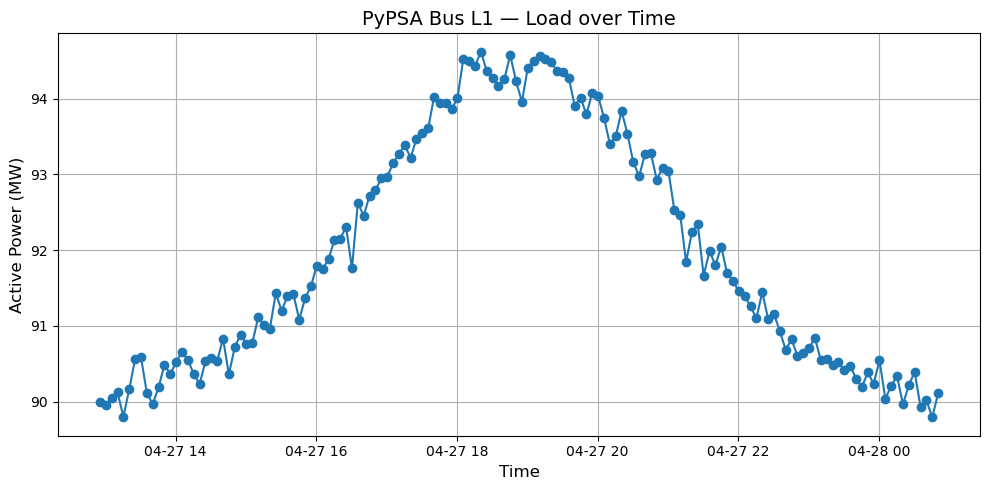

In [103]:
import matplotlib.pyplot as plt

def plot_load(network, bus_id):
    loads = network.loads
    load_bus_name = loads.index[bus_id]
    p_series = network.loads_t.p_set[load_bus_name]

    plt.figure(figsize=(10,5))
    plt.plot(p_series.index, p_series.values, marker='o', linestyle='-')
    plt.grid(True)
    plt.title(f"PyPSA Bus {load_bus_name} — Load over Time", fontsize=14)
    plt.ylabel("Active Power (MW)", fontsize=12)
    plt.xlabel("Time", fontsize=12)
    plt.tight_layout()
    plt.show()

# Example
plot_load(network, bus_id=1)

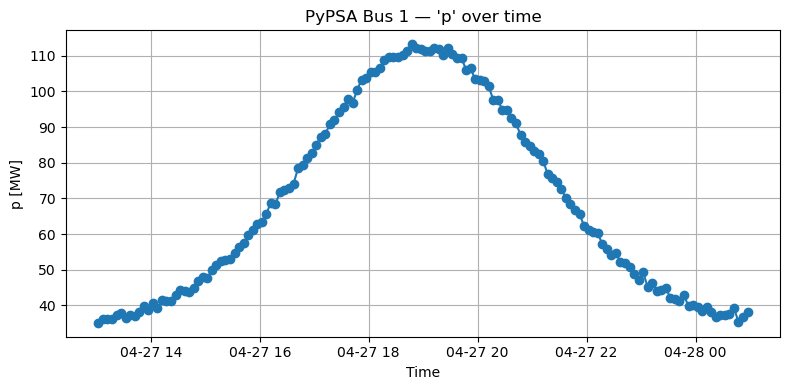

In [118]:
import matplotlib.pyplot as plt
# Ensure bus_id is a string if needed
bus_id = '1'

# Extract the time-series
series = getattr(network.buses_t, 'p').loc[:, bus_id]
#series =  wec_grid.pypsaObj.pypsa_object.loads_t.p['L0']


# Plot
plt.figure(figsize=(8, 4))
plt.plot(series.index, series.values, marker='o')
plt.title(f"PyPSA Bus {bus_id} — 'p' over time")
plt.xlabel("Time")
plt.ylabel(f"p [MW]")
plt.grid(True)
plt.tight_layout()
plt.show()

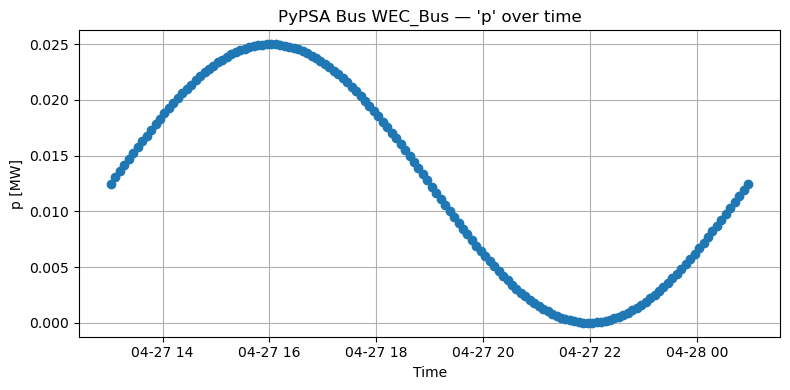

In [117]:
import matplotlib.pyplot as plt
# Ensure bus_id is a string if needed
bus_id = 'WEC_Bus'

# Extract the time-series
series = getattr(network.buses_t, 'p').loc[:, bus_id]
#series =  wec_grid.pypsaObj.pypsa_object.loads_t.p['L0']


# Plot
plt.figure(figsize=(8, 4))
plt.plot(series.index, series.values, marker='o')
plt.title(f"PyPSA Bus {bus_id} — 'p' over time")
plt.xlabel("Time")
plt.ylabel(f"p [MW]")
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
for load_id, base_load in p_load_values.items():
    break

In [38]:
base_load.values[0]

97.0

In [36]:
load_id

'L0'

In [88]:
import pypsa
from pypsa import examples
n = pypsa.examples.model_energy()

AttributeError: module 'pypsa.examples' has no attribute 'model_energy'

In [ ]:
import pypsa
from grg_pssedata.io import parse_psse_case_file

def import_raw_to_pypsa(case_file):
    """
    Builds a PyPSA Network from a parsed PSS/E RAW case file,
    correctly assigning each Bus’ control mode (PQ/PV/Slack)
    based on the PSS/E bus type (ide).
    """
    case    = parse_psse_case_file(case_file)
    network = pypsa.Network(s_n_mva=case.sbase)  # [MVA]
    
    return network, case
    
case_file = "../WecGrid/models/grid_models/IEEE_24_bus.RAW"
network, case = import_raw_to_pypsa(case_file)



    case    = parse_psse_case_file(case_file)
    network = pypsa.Network(s_n_mva=case.sbase)  # [MVA]

    # Map PSS/E ide → PyPSA control
    ide_to_ctrl = {1: "PQ", 2: "PV", 3: "Slack"}

    # Build a lookup of bus index → Bus object
    bus_map = {b.i: b for b in case.buses}

    # 1) Add all buses, now with control
    for bus in case.buses:
        network.add("Bus",
            name          = bus.name.strip(),  # [-]
            v_nom         = bus.basekv,        # [kV]
            x             = getattr(bus, "x",   0.0),  # [° or rad]
            y             = getattr(bus, "y",   0.0),  # [° or rad]
            carrier       = "AC",              # [-]
            unit          = "MW",              # [-]
            v_mag_pu_set  = bus.vm,            # [pu]
            v_mag_pu_min  = bus.nvlo,          # [pu]
            v_mag_pu_max  = bus.nvhi,          # [pu]
            control       = ide_to_ctrl.get(bus.ide, "PQ"),  # [-]
        )

    # 2) Add all non‐transformer branches as Lines
    for br in case.branches:
        lname = f"{br.i}-{br.j}-{br.ckt}".replace(" ", "")
        # Compute Ohm‐level and Siemens‐level parameters
        V_bus   = network.buses.at[str(br.i), "v_nom"] * 1e3  # [V]
        S_base  = case.sbase * 1e6                           # [VA]
        Z_base  = V_bus**2 / S_base                          # [Ω]
        Y_base  = 1 / Z_base                                 # [S]

        network.add("Line",
            name            = lname,               # [-]
            bus0            = str(br.i),           # [-]
            bus1            = str(br.j),           # [-]
            type            = "",                  # [-]
            r               = br.r  * Z_base,      # [Ω]
            x               = br.x  * Z_base,      # [Ω]
            g               = (br.gi + br.gj) * Y_base,  # [S]
            b               = (br.bi + br.bj) * Y_base,  # [S]
            s_nom           = br.ratea,            # [MVA]
            s_nom_min       = 0.0,                 # [MVA]
            s_nom_max       = br.ratea,            # [MVA]
            s_nom_extendable=False,                # [-]
            capital_cost    = 0.0,                 # [currency/MVA]
            length          = br.len,              # [km]
            carrier         = "AC",                # [-]
            num_parallel    = 1.0,                 # [-]
        )

    # 3) Add all in‐service generators
    for g in case.generators:
        if g.stat != 1:
            continue

        gname   = f"{g.i}-{g.id.strip()}"
        ctrl    = ide_to_ctrl.get(bus_map[g.i].ide, "PQ")

        network.add("Generator",
            name          = gname,                # [-]
            bus           = str(g.i),             # [-]
            control       = ctrl,                 # [-]
            p_nom         = g.pt,                 # [MW]
            p_set         = g.pg,                 # [MW]
            q_set         = g.qg,                 # [MVar]
            p_min_pu      = (g.pb / g.pt) if g.pt else 0.0,  # [pu]
            p_max_pu      = 1.0,                  # [pu]
            marginal_cost = 0.0,                  # [currency/MWh]
            carrier       = "AC",                 # [-]
            efficiency    = 1.0,                  # [pu]
        )

    # 4) Two‐winding transformers → Transformers
    for tx in case.transformers:
        p1, p2, w1, w2 = tx.p1, tx.p2, tx.w1, tx.w2
        tname = f"{p1.i}-{p1.j}-{p1.ckt}".strip()

        s_nom = w1.rata                       # [MVA]

        # raw r12, x12 are pu on p2.sbase12 → convert to pu on s_nom
        r_pu = p2.r12 * (p2.sbase12 / s_nom)  # [pu]
        x_pu = p2.x12 * (p2.sbase12 / s_nom)  # [pu]

        # magnetizing admittance in pu on system base → pu on s_nom
        g_pu = p1.mag1 * (case.sbase / s_nom) # [pu]
        b_pu = p1.mag2 * (case.sbase / s_nom) # [pu]

        network.add("Transformer",
            name             = tname,           # [-]
            bus0             = str(p1.i),       # [-]
            bus1             = str(p1.j),       # [-]
            type             = "",              # [-]
            model            = "t",             # [-]
            r                = r_pu,            # [pu]
            x                = x_pu,            # [pu]
            s_nom            = s_nom,           # [MVA]
            s_nom_extendable = False,           # [-]
            s_nom_max        = s_nom,           # [MVA]
            tap_ratio        = w1.windv,        # [pu]
            tap_side         = 0,               # [-]
            phase_shift      = w1.ang,          # [°]
            capital_cost     = 0.0,             # [currency/MVA]
            num_parallel     = 1.0,             # [-]
            g                = g_pu,            # [pu]
            b                = b_pu,            # [pu]
        )

    # 5) Loads
    for L in case.loads:
        if L.status != 1:
            continue

        lname = f"{L.i}-load{L.id.strip()}"
        network.add("Load",
            name    = lname,   # [-]
            bus     = str(L.i),# [-]
            p_set   = L.pl,    # [MW]
            q_set   = L.ql,    # [MVar]
            carrier = "AC",    # [-]
        )

    # 6) Switched shunts (initial susceptance only)
    for ss in case.switched_shunts:
        if ss.stat != 1:
            continue

        bus_name       = str(ss.i)                         # [-]
        V_nom_V        = network.buses.at[bus_name, "v_nom"] * 1e3  # [V]
        Q_at_1pu_VA    = ss.binit      * 1e6               # [VA]
        b_siemens      = Q_at_1pu_VA   / V_nom_V**2         # [S]

        network.add("ShuntImpedance",
            name    = f"{bus_name}-sh{ss.index}",  # [-]
            bus     = bus_name,                    # [-]
            g       = 0.0,                         # [S]
            b       = b_siemens,                   # [S]
            sign    = -1.0,                        # [-]
        )

    return network, case

In [30]:
case_file = "../WecGrid/models/grid_models/IEEE_24_bus.RAW"
network, case = import_raw_to_pypsa(case_file)
#erify_generators(network, case)
#verify_buses(network, case)
#verify_bus_mapping(network, case)
# verify_lines(network, case)
# verify_transformers(network, case)
# verify_loads(network, case)
# verify_switched_shunts(network, case)
print(network.pf())

case data: 0     100.00  33  0  0  60.00       
record 1: 
record 2: 
parsed 24 buses
parsed 16 loads
parsed 0 fixed shunts
parsed 11 generators
parsed 32 branches
parsed 6 transformers
parsed 1 areas
parsed 0 two terminal dc lines
parsed 0 vsc dc lines
parsed 0 transformer corrections
parsed 0 multi-terminal dc lines
parsed 0 multi-section lines
parsed 1 zones
parsed 0 inter-area transfers
parsed 1 owners
parsed 0 facts devices
parsed 2 switched shunts
parsed 0 induction machines
un-parsed lines:
  Q

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.038003 seconds


{'n_iter': SubNetwork  0
snapshot     
now         4, 'error': SubNetwork             0
snapshot                
now         1.917454e-07, 'converged': SubNetwork     0
snapshot        
now         True}


In [52]:
t = case.transformers[1]
t

In [50]:
for idx, br in enumerate(case.branches):
    # give every branch a unique L0, L1, L2, … name
    lname = f"L{idx}"
    print(f"branch {br.i}-{br.j}-{br.ckt} → {lname}")

branch 1-2-1  → L0
branch 3-1-1  → L1
branch 1-5-1  → L2
branch 2-4-1  → L3
branch 2-6-1  → L4
branch 3-9-1  → L5
branch 4-9-1  → L6
branch 10-6-1  → L7
branch 7-8-1  → L8
branch 8-9-1  → L9
branch 8-10-1  → L10
branch 11-13-1  → L11
branch 11-14-1  → L12
branch 12-13-1  → L13
branch 12-23-1  → L14
branch 23-13-1  → L15
branch 14-16-1  → L16
branch 16-15-1  → L17
branch 15-21-1  → L18
branch 21-15-2  → L19
branch 15-24-1  → L20
branch 16-17-1  → L21
branch 16-19-1  → L22
branch 17-18-1  → L23
branch 17-22-1  → L24
branch 18-21-1  → L25
branch 18-21-2  → L26
branch 19-20-1  → L27
branch 19-20-2  → L28
branch 20-23-1  → L29
branch 20-23-2  → L30
branch 21-22-1  → L31


In [ ]:
br.

In [175]:
network.pf()

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 7 iterations with error of 0.000000 in 0.143951 seconds


{'n_iter': SubNetwork  0
 snapshot     
 now         7,
 'error': SubNetwork             0
 snapshot                
 now         1.715283e-09,
 'converged': SubNetwork     0
 snapshot        
 now         True}

In [87]:
in_service = [g for g in case.generators if g.stat == 1]
in_service
for g in in_service:
    gname = f"{g.i}-{g.id.strip()}"
    assert gname in network.generators.index, f"Generator {gname} missing"
    ng = network.generators.loc[gname]

In [88]:
ng

attribute
bus                         23
control                     PQ
type                          
p_nom                   1000.0
p_nom_extendable         False
p_nom_min                  0.0
p_nom_max                  inf
p_min_pu                   0.0
p_max_pu                   1.0
p_set                    200.0
q_set                      0.0
sign                       1.0
carrier                     AC
marginal_cost              0.0
build_year                   0
lifetime                   inf
capital_cost               0.0
efficiency                 1.0
committable              False
start_up_cost              0.0
shut_down_cost             0.0
min_up_time                  0
min_down_time                0
up_time_before               1
down_time_before             0
ramp_limit_up              NaN
ramp_limit_down            NaN
ramp_limit_start_up        1.0
ramp_limit_shut_down       1.0
p_nom_opt                  0.0
Name: 23-1, dtype: object

In [ ]:
case.tk.Button(root, text="")

In [ ]:
from grg_pssedata.io import parse_psse_case_file

# 1) Parse the case
case = parse_psse_case_file(case_file)

case.to_psse() # can probably use this to write the case back to a file and check if it is the same as the original
case.generators # list of generators structs 
case.sbase
case.buses # list of bus structs
case.branches # list of branch structs

case data: 0     100.00  33  0  0  60.00       
record 1: 
record 2: 
parsed 24 buses
parsed 16 loads
parsed 0 fixed shunts
parsed 11 generators
parsed 32 branches
parsed 6 transformers
parsed 1 areas
parsed 0 two terminal dc lines
parsed 0 vsc dc lines
parsed 0 transformer corrections
parsed 0 multi-terminal dc lines
parsed 0 multi-section lines
parsed 1 zones
parsed 0 inter-area transfers
parsed 1 owners
parsed 0 facts devices
parsed 2 switched shunts
parsed 0 induction machines
un-parsed lines:
  Q



AttributeError: 'Case' object has no attribute 'lines'

In [61]:
# Verification script for Jupyter notebook

import difflib
from grg_pssedata.io import parse_psse_case_file

def normalize(lines):
    """Strip whitespace and remove empty/comment lines."""
    return [
        line.strip() 
        for line in lines
        if line.strip() and not line.strip().startswith('!')
    ]

# 1) Set the path to your PSSE RAW file
raw_file = "../WecGrid/models/grid_models/IEEE_24_bus.RAW"

# 2) Read and normalize the original file
with open(raw_file, 'r') as f:
    original_lines = f.readlines()
original = normalize(original_lines)

# 3) Parse the case and regenerate PSSE text
case = parse_psse_case_file(raw_file)
regenerated_lines = case.to_psse().splitlines()
regenerated = normalize(regenerated_lines)

# 4) Compare original vs. regenerated
if original == regenerated:
    print('✅ SUCCESS: Regenerated RAW matches original.')
else:
    print('❌ FAILURE: Differences detected:')
    for diff in difflib.unified_diff(
            original, regenerated,
            fromfile='original', tofile='regenerated',
            lineterm=''
        ):
        print(diff)

# 5) Print a brief summary of the parsed case object
print('\n=== Parsed Case Summary ===')
print(f'  System MVA base:      {case.sbase}')
print(f'  # of buses:           {len(case.buses)}')
print(f'  # of loads:           {len(case.loads)}')
print(f'  # of fixed shunts:    {len(case.fixed_shunts)}')
print(f'  # of generators:      {len(case.generators)}')
print(f'  # of branches:        {len(case.branches)}')
print(f'  # of transformers:    {len(case.transformers)}')
print(f'  # of switched shunts: {len(case.switched_shunts)}')
print(f'  # of zones:           {len(case.zones)}')
print(f'  # of owners:          {len(case.owners)}')
print('===========================')

# 6) Inspect first bus and first generator as an example
if case.buses:
    b = case.buses[0]
    print(f"\nFirst bus → i={b.i}, name={b.name}, basekv={b.basekv}, vm={b.vm}, va={b.va}")

if case.generators:
    g = case.generators[0]
    print(f"First generator → bus={g.i}, pg={g.pg}, qg={g.qg}, vs={g.vs}, qt={g.qt}, qb={g.qb}")

❌ FAILURE: Differences detected:
--- original
+++ regenerated
@@ -1,132 +1,133 @@
-0,    100.00, 33, 0, 0, 60.00       / April 12, 2016 13:35:48; Simulator Version 19; BuildDate 2016_2_6
-1,'1           ', 138.0000,3,   1,   1,   1,1.00000,   0.0000, 1.10000, 0.90000, 1.10000, 0.90000
-2,'2           ', 138.0000,2,   1,   1,   1,0.99783,   0.0102, 1.10000, 0.90000, 1.10000, 0.90000
-3,'3           ', 138.0000,1,   1,   1,   1,0.86395,  10.7472, 1.10000, 0.90000, 1.10000, 0.90000
-4,'4           ', 138.0000,1,   1,   1,   1,0.88721,  -0.4167, 1.10000, 0.90000, 1.10000, 0.90000
-5,'5           ', 138.0000,1,   1,   1,   1,0.92693,  -0.2237, 1.10000, 0.90000, 1.10000, 0.90000
-6,'6           ', 138.0000,1,   1,   1,   1,0.90837,   0.3902, 1.10000, 0.90000, 1.10000, 0.90000
-7,'7           ', 138.0000,2,   1,   1,   1,0.79668,  -0.5811, 1.10000, 0.90000, 1.10000, 0.90000
-8,'8           ', 230.0000,1,   1,   1,   1,0.80581,  -0.8692, 1.10000, 0.90000, 1.10000, 0.90000
-9,'9           ', 13

case data: 0     100.00  33  0  0  60.00       
record 1: 
record 2: 
parsed 24 buses
parsed 16 loads
parsed 0 fixed shunts
parsed 11 generators
parsed 32 branches
parsed 6 transformers
parsed 1 areas
parsed 0 two terminal dc lines
parsed 0 vsc dc lines
parsed 0 transformer corrections
parsed 0 multi-terminal dc lines
parsed 0 multi-section lines
parsed 1 zones
parsed 0 inter-area transfers
parsed 1 owners
parsed 0 facts devices
parsed 2 switched shunts
parsed 0 induction machines
un-parsed lines:
  Q



In [80]:
from collections import defaultdict
from grg_pssedata.io import parse_psse_case_file

# 1) Parse the case
case = parse_psse_case_file(case_file)

# 2) Build bus→Generator list
bus_to_gens = defaultdict(list)
for gen in case.generators:
    if gen.stat == 1:               # only in‐service
        bus_to_gens[gen.i].append(gen)

# 3) Optional: annotate each Generator with a 'control' field
ide_map = {1: "PQ", 2: "PV", 3: "Slack", 4: "Isolated"}
# build a quick bus lookup
bus_map = {b.i: b for b in case.buses}
for gen in case.generators:
    parent = bus_map[gen.i]
    gen.control = ide_map[parent.ide]

# 4) Now print a combined table: bus, control, gens
for bus in case.buses:
    ctrl = ide_map.get(bus.ide, bus.ide)
    gens = bus_to_gens.get(bus.i, [])
    names = [g.id.strip() for g in gens]
    print(f"Bus {bus.i:2d} | control = {ctrl:8s} | gens = {names}")

Bus  1 | control = Slack    | gens = ['1']
Bus  2 | control = PV       | gens = ['1']
Bus  3 | control = PQ       | gens = []
Bus  4 | control = PQ       | gens = []
Bus  5 | control = PQ       | gens = []
Bus  6 | control = PQ       | gens = []
Bus  7 | control = PV       | gens = ['1']
Bus  8 | control = PQ       | gens = []
Bus  9 | control = PQ       | gens = []
Bus 10 | control = PQ       | gens = []
Bus 11 | control = PQ       | gens = []
Bus 12 | control = PQ       | gens = []
Bus 13 | control = PV       | gens = ['1']
Bus 14 | control = PV       | gens = ['1']
Bus 15 | control = PV       | gens = ['1']
Bus 16 | control = PV       | gens = ['1']
Bus 17 | control = PQ       | gens = []
Bus 18 | control = PV       | gens = ['1']
Bus 19 | control = PQ       | gens = []
Bus 20 | control = PQ       | gens = []
Bus 21 | control = PV       | gens = ['1']
Bus 22 | control = PV       | gens = ['1']
Bus 23 | control = PV       | gens = ['1']
Bus 24 | control = PQ       | gens = []


case data: 0     100.00  33  0  0  60.00       
record 1: 
record 2: 
parsed 24 buses
parsed 16 loads
parsed 0 fixed shunts
parsed 11 generators
parsed 32 branches
parsed 6 transformers
parsed 1 areas
parsed 0 two terminal dc lines
parsed 0 vsc dc lines
parsed 0 transformer corrections
parsed 0 multi-terminal dc lines
parsed 0 multi-section lines
parsed 1 zones
parsed 0 inter-area transfers
parsed 1 owners
parsed 0 facts devices
parsed 2 switched shunts
parsed 0 induction machines
un-parsed lines:
  Q



In [ ]:
case.buses[2].ide
#ide (int): bus type, PQ = 1, PV = 2, reference = 3, isolated = 4

1

In [44]:
from collections import defaultdict
from grg_pssedata.io import parse_psse_case_file

# 1) Parse the case
case = parse_psse_case_file(case_file)


case data: 0     100.00  33  0  0  60.00       
record 1: 
record 2: 
parsed 24 buses
parsed 16 loads
parsed 0 fixed shunts
parsed 11 generators
parsed 32 branches
parsed 6 transformers
parsed 1 areas
parsed 0 two terminal dc lines
parsed 0 vsc dc lines
parsed 0 transformer corrections
parsed 0 multi-terminal dc lines
parsed 0 multi-section lines
parsed 1 zones
parsed 0 inter-area transfers
parsed 1 owners
parsed 0 facts devices
parsed 2 switched shunts
parsed 0 induction machines
un-parsed lines:
  Q



In [45]:
case.sbase

100.0

In [48]:
import pypsa
from grg_pssedata.io import parse_psse_case_file

def build_pypsa_network_from_parser(case_file):
    """
    Builds a PyPSA Network from a parsed PSS/E RAW case file,
    with generator controls inherited from bus.ide (1=PQ, 2=PV, 3=Slack, 4=PQ),
    and then propagates them to the buses.
    """
    # 1) Parse PSS/E case
    case = parse_psse_case_file(case_file)

    # 2) Create network, matching the PSS/E MVA base
    network = pypsa.Network(s_n_mva=case.sbase)

    # 3) Quick lookup: bus_number → Bus struct
    bus_map = {b.i: b for b in case.buses}

    # 4) PSS/E ide → PyPSA control mapping
    ide_to_control = {
        1: "PQ",
        2: "PV",
        3: "Slack",
        4: "PQ",   # isolated
    }

    # 5) Add buses
    for bus in case.buses:
        network.add("Bus", str(bus.i),
                    v_nom=bus.basekv,
                    v_mag_pu_set=bus.vm,
                    v_mag_pu_min=bus.nvlo,
                    v_mag_pu_max=bus.nvhi,
                    v_ang=bus.va,
                    carrier="AC",
                    )

    # 6) Add lines
    for br in case.branches:
        if br.st == 0:
            continue
        network.add("Line", f"line_{br.i}_{br.j}_{br.ckt.strip()}",
                    bus0=str(br.i),
                    bus1=str(br.j),
                    r=br.r,
                    x=br.x,
                    g=br.gi + br.gj,
                    b=br.b,
                    s_nom=br.ratea or 1e6,
                    length=br.len or 0.0,
                    num_parallel=1.0,
                    carrier="AC",
                    )

    # 7) Add generators, inheriting control from their parent bus
    for g in case.generators:
        if g.stat == 0:
            continue
        p_nom = g.pt if g.pt > 0 else (g.pg or 1.0)
        parent_bus = bus_map[g.i]
        control = ide_to_control.get(parent_bus.ide, "PQ")
        network.add("Generator", f"gen_{g.i}_{g.id.strip()}",
                    bus=str(g.i),
                    p_nom=p_nom,
                    p_min_pu=g.pb / p_nom,
                    p_max_pu=g.pt / p_nom,
                    p_set=g.pg,
                    q_set=g.qg,
                    control=control,    # must be "PQ","PV" or "Slack" Components — PyPSA: Python for Power System Analysis.pdf](file-service://file-Ci26WKdhoZAdtVkavwxqmu)
                    carrier="AC",
                    )

    # 8) Add loads
    for load in case.loads:
        if load.status == 0:
            continue
        network.add("Load", f"load_{load.i}_{load.id.strip()}",
                    bus=str(load.i),
                    p_set=load.pl,
                    q_set=load.ql,
                    carrier="AC",
                    )

  # inside your build_pypsa_network_from_parser, replace the transformer block with:

    for tx in case.transformers:
        if tx.p1.stat == 0:
            continue

        # PSS/E gives r12, x12 in pu on transformer's MVA base (tx.w1.rata)
        # PyPSA wants r,x in pu on network base (case.sbase)
        scale = tx.w1.rata / case.sbase
        r_pu = tx.p2.r12 * scale
        x_pu = tx.p2.x12 * scale

        # PSS/E mag1/mag2 are shunt admittances in pu on rata; convert to pu on sbase
        g_pu = (tx.p1.mag1 or 0.0) * scale
        b_pu = (tx.p1.mag2 or 0.0) * scale

        network.add("Transformer",
                    name   = f"tx_{tx.p1.i}_{tx.p1.j}_{tx.p1.ckt.strip()}",
                    bus0   = str(tx.p1.i),
                    bus1   = str(tx.p1.j),
                    r      = r_pu,
                    x      = x_pu,
                    g      = g_pu,
                    b      = b_pu,
                    s_nom  = tx.w1.rata,           # rated MVA
                    tap_ratio   = tx.w1.windv or 1.0,
                    phase_shift = getattr(tx.w1, "ang", 0.0),
                    model       = "t",
        )

    # 6) Fixed shunts (P in MW, Q in MVAr at nominal voltage)
    for fs in case.fixed_shunts:
        if fs.status != 1: continue
        bus_kv = bus_map[fs.i].basekv
        # P (MW) → g (Siemens):  g = P*1e6 / (V*1e3)**2
        g_si = fs.gl * 1e6 / (bus_kv*1e3)**2
        b_si = fs.bl * 1e6 / (bus_kv*1e3)**2
        network.add("ShuntImpedance", f"fshunt_{fs.i}_{fs.id.strip()}",
                bus=str(fs.i),
                g=g_si,
                b=b_si,
                sign=-1)    # consumption components.txt](file-service://file-JyZ1ukgCaAbc7BAgtXqYBX)

    # 7) Switched shunts (initial Q in MVAr)
    for ss in case.switched_shunts:
        if ss.stat != 1: continue
        bus_kv = bus_map[ss.i].basekv
        b_si   = ss.binit * 1e6 / (bus_kv*1e3)**2
        network.add("ShuntImpedance", f"sshunt_{ss.i}",
                bus=str(ss.i),
                g=0.0,
                b=b_si,
                sign=-1)
    # 12) Propagate generator controls to buses
    # This populates network.buses.control from attached generators Components — PyPSA: Python for Power System Analysis.pdf](file-service://file-Ci26WKdhoZAdtVkavwxqmu)
    network.determine_network_topology()

    # 13) Debug summary
    print(f"✅ buses: {len(network.buses)}, lines: {len(network.lines)}, "
          f"gens: {len(network.generators)}, loads: {len(network.loads)}, "
          f"xfmrs: {len(network.transformers)}, shunts: {len(network.shunt_impedances)}")

    return network, case

In [50]:
case_file = "../WecGrid/models/grid_models/IEEE_24_bus.RAW"
network, case = build_pypsa_network_from_parser(case_file)

case data: 0     100.00  33  0  0  60.00       
record 1: 
record 2: 
parsed 24 buses
parsed 16 loads
parsed 0 fixed shunts
parsed 11 generators
parsed 32 branches
parsed 6 transformers
parsed 1 areas
parsed 0 two terminal dc lines
parsed 0 vsc dc lines
parsed 0 transformer corrections
parsed 0 multi-terminal dc lines
parsed 0 multi-section lines
parsed 1 zones
parsed 0 inter-area transfers
parsed 1 owners
parsed 0 facts devices
parsed 2 switched shunts
parsed 0 induction machines
un-parsed lines:
  Q



✅ buses: 24, lines: 32, gens: 11, loads: 16, xfmrs: 6, shunts: 2


In [52]:
network.pf()

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 6 iterations with error of 0.000000 in 0.066964 seconds


{'n_iter': SubNetwork  0
 snapshot     
 now         6,
 'error': SubNetwork             0
 snapshot                
 now         3.494279e-09,
 'converged': SubNetwork     0
 snapshot        
 now         True}

In [28]:
def debug_parsing(network, case, snapshot="now"):
    """
    Quick‐and‐dirty PF‐vs‐RAW sanity checks:
      1) static bus data (nominal volts, setpoints, controls)
      2) PF results: bus angles & net injections
      3) static generator data (p‐limits, controls)
      4) PF generator dispatch (p_pf)
    """
    import pandas as pd

    # 1) Static bus table
    print("\n=== Buses (static attrs) ===")
    bus_cols = ["v_nom", "v_mag_pu_set", "v_mag_pu_min", "v_mag_pu_max", "control"]
    bus_keep = [c for c in bus_cols if c in network.buses.columns]
    print(network.buses[bus_keep])

    # 2) PF‐time bus results
    if hasattr(network.buses_t, "v_ang") and snapshot in network.buses_t.v_ang.index:
        print(f"\n=== Bus angles @ '{snapshot}' (rad) ===")
        print(network.buses_t.v_ang.loc[snapshot].to_frame("v_ang"))
    else:
        print(f"\n(no v_ang in buses_t for snapshot '{snapshot}')")

    if "p" in network.buses_t and snapshot in network.buses_t.p.index:
        print(f"\n=== Bus P injections @ '{snapshot}' (MW) ===")
        print(network.buses_t.p.loc[snapshot].to_frame("p_inj"))
    else:
        print(f"\n(no p in buses_t for snapshot '{snapshot}')")

    # 3) Static generator table
    print("\n=== Generators (static attrs) ===")
    gen_cols = ["bus", "p_nom", "p_min_pu", "p_max_pu", "control"]
    gen_keep = [c for c in gen_cols if c in network.generators.columns]
    print(network.generators[gen_keep])

    # 4) PF‐time generator dispatch
    if "p" in network.generators_t and snapshot in network.generators_t.p.index:
        print(f"\n=== Generator dispatch @ '{snapshot}' (MW) ===")
        p_pf = network.generators_t.p.loc[snapshot]
        print(p_pf.to_frame("p_pf"))
    else:
        print(f"\n(no p in generators_t for snapshot '{snapshot}')")

    # 5) Compare against RAW case
    print("\n=== RAW → PyPSA mapping ===")
    gen_idx = list(network.generators.index)
    print("network.generators.index:", gen_idx)
    for g in case.generators:
        if g.stat == 0:
            continue
        name = f"gen_{g.i}_{g.id.strip()}"
        hits = network.generators.index[network.generators.bus == str(g.i)].tolist()
        print(f" RAW gen at bus={g.i!r}, id={g.id!r} → expect '{name}', found {hits}")
# Example usage:
network.pf()
debug_parsing(network, case, snapshot="now")

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 100 iterations with error of 92118808991935237719602934632836759552.000000 in 0.938697 seconds



=== Buses (static attrs) ===
attribute  v_nom  v_mag_pu_set  v_mag_pu_min  v_mag_pu_max control
Bus                                                               
1          138.0       1.00000           0.9           1.1   Slack
2          138.0       0.99783           0.9           1.1      PV
3          138.0       0.86395           0.9           1.1      PQ
4          138.0       0.88721           0.9           1.1      PQ
5          138.0       0.92693           0.9           1.1      PQ
6          138.0       0.90837           0.9           1.1      PQ
7          138.0       0.79668           0.9           1.1      PV
8          230.0       0.80581           0.9           1.1      PQ
9          138.0       0.83528           0.9           1.1      PQ
10         138.0       0.88216           0.9           1.1      PQ
11         230.0       0.83645           0.9           1.1      PQ
12         230.0       0.84016           0.9           1.1      PQ
13         230.0       0.83731  

In [14]:
network1.generators_t.p

Generator,gen_1_1,gen_2_1,gen_7_1,gen_13_1,gen_14_1,gen_15_1,gen_16_1,gen_18_1,gen_21_1,gen_22_1,gen_23_1
snapshot,,,,,,,,,,,
now,3762.730418,67.0,64.0,200.0,0.0,274.0,245.0,144.0,294.0,150.0,200.0


In [27]:
network1.pf()

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 6 iterations with error of 0.000000 in 0.064994 seconds


{'n_iter': SubNetwork  0
 snapshot     
 now         6,
 'error': SubNetwork             0
 snapshot                
 now         3.494279e-09,
 'converged': SubNetwork     0
 snapshot        
 now         True}

In [38]:
g = case.generators[0]
g??

Type:           Generator
String form:    0 1 1  35.849 180.357 9900.0 -9900.0 1.0 0 100.0 0.0 1.0 0.0 0.0 1.0 1 100.0 1000.0 0.0 1 1.0 0 1.0 0 1.0 0 1.0 0 1.0
File:           c:\users\alexb\miniconda3\envs\happy\lib\site-packages\grg_pssedata\struct.py
Source:        
class Generator(object):
    def __init__(self, index, i, id, pg, qg, qt, qb, vs, ireg, mbase, zr, zx,
                    rt, xt, gtap, stat, rmpct, pt, pb, o1=1, f1=0, o2=0, f2=0, o3=1.0, f3=1.0, o4=1.0, f4=1.0,
                    wmod=0, wpf=1.0):
        '''This data structure contains generator parameters.

        Args:
            index (int): unique generator identifier
            i (int): the identifier of the bus that this generator is connected to
            id (string): machine identifier (not unique)
            pg (float): active power output (MW)
            qg (float): reactive power output (MVAr)
            qt (float): reactive power output upper bound (MVAr)
            qb (float): reactive power ou

In [28]:
network.generators


attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
gen_1_1,1,Slack,,1000.0,False,0.0,inf,0.0,1.0,35.849,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_2_1,2,PQ,,1000.0,False,0.0,inf,0.0,1.0,67.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_7_1,7,PQ,,1000.0,False,0.0,inf,0.0,1.0,64.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_13_1,13,PQ,,1000.0,False,0.0,inf,0.0,1.0,200.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_14_1,14,PQ,,1000.0,False,0.0,inf,0.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_15_1,15,PQ,,1000.0,False,0.0,inf,0.0,1.0,274.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_16_1,16,PQ,,1000.0,False,0.0,inf,0.0,1.0,245.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_18_1,18,PQ,,1000.0,False,0.0,inf,0.0,1.0,144.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_21_1,21,PQ,,1000.0,False,0.0,inf,0.0,1.0,294.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [ ]:
s = case.switched_shunts[0]
s.

Type:           SwitchedShunt
String form:    0 1 0 0 1 1.0 0.99 0 100.0          120.0 1 120.0 None None None None None None None None None None None None None None
File:           c:\users\alexb\miniconda3\envs\happy\lib\site-packages\grg_pssedata\struct.py
Source:        
class SwitchedShunt(object):
    def __init__(self, index, i, modsw, adjm, stat, vswhi, vswlo, swrem, rmpct, rmidnt, binit, n1, b1,
                    n2=None, b2=None, n3=None, b3=None, n4=None, b4=None, n5=None, b5=None,
                    n6=None, b6=None, n7=None, b7=None, n8=None, b8=None):
        '''This data structure contains switch shunt parameters

        Args:
            index (int): unique switched shunt identifier
            i (int): the identifier of the bus that this switched shunt is connected to
            modsw (int): control mode (locked = 0, discrete = 1, continuous = 2, ... 6) (default = 1)
            adjm (int): adjustment method (input order = 0, admittance order = 1) (default = 0)
  

In [92]:
y = case.transformers[0]
y.p2??

Type:           TransformerParametersSecondLineShort
String form:    0.0023 0.0839 100.0
File:           c:\users\alexb\miniconda3\envs\happy\lib\site-packages\grg_pssedata\struct.py
Source:        
class TransformerParametersSecondLineShort(object):
    def __init__(self, r12, x12, sbase12):
        '''This data structure contains transformer parameters for the second line of two winding transformers.

        Args:
            r12 (float): resistance between terminal i and j (default 0.0)
            x12 (float): reactance between terminal i and j
            sbase12 (float): the MVA base between terminal i and j
        '''

        args = [r12, sbase12]
        _set_defaults(args, TRANSFORMER_SLS_DEFAULTS)
        r12, sbase12 = args

        self.r12 = float(r12)
        self.x12 = float(x12)
        self.sbase12 = float(sbase12)

    def __str__(self):
        data = [self.r12, self.x12, self.sbase12]
        return ' '.join([str(x) for x in data])

    def __eq__(self, other):
 

In [11]:
network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
gen_1_1,1,PQ,,0.0,False,0.0,inf,0.0,1.0,35.849,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_2_1,2,PQ,,0.0,False,0.0,inf,0.0,1.0,67.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_7_1,7,PQ,,0.0,False,0.0,inf,0.0,1.0,64.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_13_1,13,PQ,,0.0,False,0.0,inf,0.0,1.0,200.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_14_1,14,PQ,,0.0,False,0.0,inf,0.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_15_1,15,PQ,,0.0,False,0.0,inf,0.0,1.0,274.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_16_1,16,PQ,,0.0,False,0.0,inf,0.0,1.0,245.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_18_1,18,PQ,,0.0,False,0.0,inf,0.0,1.0,144.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gen_21_1,21,PQ,,0.0,False,0.0,inf,0.0,1.0,294.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [6]:
print("Total generation (MW):", network.generators.p_set.sum())
print("Total load (MW):", network.loads.p_set.sum())

Total generation (MW): 1673.849
Total load (MW): 1619.0


In [7]:
from pandapower.networks.power_system_test_cases import case24_ieee_rts
case24 = pp.networks.power_system_test_cases.case24_ieee_rts()
case24

INFO:pandapower.convert_format:These dtypes could not be corrected: {'trafo': ['tap_min', 'tap_max']}


This pandapower network includes the following parameter tables:
   - bus (24 elements)
   - load (17 elements)
   - sgen (22 elements)
   - gen (10 elements)
   - shunt (1 element)
   - ext_grid (1 element)
   - line (33 elements)
   - trafo (5 elements)
   - poly_cost (33 elements)
   - bus_geodata (24 elements)

In [1]:
pypsa.Network.import_components_from_dataframe

NameError: name 'pypsa' is not defined

In [23]:
import pandapower as pp 
import pandapower.networks as pn 
from pandapower.networks.power_system_test_cases import case24_ieee_rts
case24 = pp.networks.power_system_test_cases.case24_ieee_rts()
n = pypsa.Network()
n.import_from_pandapower_net(case24)

INFO:pandapower.convert_format:These dtypes could not be corrected: {'trafo': ['tap_min', 'tap_max']}
Unsupported features include: three-winding transformers, switches, in_service status, shunt impedances and tap positions of transformers.
ERROR:pypsa.io:Error, new components for Load are not unique
ERROR:pypsa.io:Error, new components for Generator are not unique
ERROR:pypsa.io:Error, new components for Line are not unique
ERROR:pypsa.io:Error, new components for Transformer are not unique


In [43]:
from pypsa import Network

In [26]:
pypsa.examples.Network??

Init signature:
pypsa.examples.Network(
    import_name=None,
    name='',
    ignore_standard_types=False,
    override_components=None,
    override_component_attrs=None,
    **kwargs,
)
Source:        
class Network(Basic):
    """
    Network container for all buses, one-ports and branches.

    Parameters
    ----------
    import_name : string, Path
        Path to netCDF file, HDF5 .h5 store or folder of CSV files from which to
        import network data.
    name : string, default ""
        Network name.
    ignore_standard_types : boolean, default False
        If True, do not read in PyPSA standard types into standard types
        DataFrames.
    override_components : pandas.DataFrame
        If you want to override the standard PyPSA components in
        pypsa.components.components, pass it a DataFrame with index of component
        name and columns of list_name and description, following the format of
        pypsa.components.components. See git repository examples/new

In [ ]:
temp.transformers[0]

In [9]:
import pypsa

def parse_raw_to_pypsa(raw_path):
    network = pypsa.Network()

    with open(raw_path, 'r') as f:
        lines = f.readlines()

    section = None
    for line in lines:
        line = line.strip()
        if not line or line.startswith("0 /"):
            section = None
        elif "BEGIN BUS DATA" in line:
            section = "BUS"
        elif "BEGIN LOAD DATA" in line:
            section = "LOAD"
        elif "BEGIN GENERATOR DATA" in line:
            section = "GEN"
        elif "BEGIN BRANCH DATA" in line:
            section = "LINE"
        elif "BEGIN TRANSFORMER DATA" in line:
            section = "XFMR"
        elif section == "BUS" and not line.startswith("0"):
            parts = line.split(",")
            bus_id = parts[0].strip()
            base_kv = float(parts[2].strip())
            network.add("Bus", f"Bus{bus_id}", v_nominal=base_kv)

        elif section == "LOAD" and not line.startswith("0"):
            parts = line.split(",")
            bus_id = parts[0].strip()
            p_mw = float(parts[5].strip())
            q_mvar = float(parts[6].strip())
            if p_mw > 0 or q_mvar > 0:
                network.add("Load", f"Load{bus_id}", bus=f"Bus{bus_id}", p_set=p_mw, q_set=q_mvar)

        elif section == "GEN" and not line.startswith("0"):
            parts = line.split(",")
            bus_id = parts[0].strip()
            p_mw = float(parts[2].strip())
            vm_pu = float(parts[6].strip())
            network.add("Generator", f"Gen{bus_id}", bus=f"Bus{bus_id}", p_set=p_mw, control="PQ", vm_pu=vm_pu)

        elif section == "LINE" and not line.startswith("0"):
            parts = line.split(",")
            from_bus = parts[0].strip()
            to_bus = parts[1].strip()
            r = float(parts[3].strip())
            x = float(parts[4].strip())
            b = float(parts[5].strip())
            network.add("Line", f"Line{from_bus}_{to_bus}", bus0=f"Bus{from_bus}", bus1=f"Bus{to_bus}", r=r, x=x, b=b)

        elif section == "XFMR" and not line.startswith("0"):
            parts = line.split(",")
            if len(parts) >= 3:
                from_bus = parts[0].strip()
                to_bus = parts[1].strip()
                tap_ratio = 1.0  # Default unless parsed differently later
                network.add("Transformer", f"Transformer{from_bus}_{to_bus}",
                            bus0=f"Bus{from_bus}", bus1=f"Bus{to_bus}",
                            tap_ratio=tap_ratio)

    return network

# Example usage:
case_file = "../WecGrid/models/grid_models/IEEE_24_bus.RAW"

network = parse_raw_to_pypsa(case_file)

In [10]:
network

Empty PyPSA Network
Components: none
Snapshots: 1

In [ ]:
import pypsa


net = pypsa.Network()

net.add("Bus", "Bus1", v_nom=138)
net.add("Bus", "Bus2", v_nom=138)

net.add("Transformer", "T1",
    bus0="Bus1",
    bus1="Bus2",
    x=0.04,
    r=0.01,
    tap_ratio=0.95,   # Set manually!
    s_nom=100
)

net.add("Load", "L1", bus="Bus2", p_set=20, q_set=5)

In [6]:
net.transformers

attribute,bus0,bus1,type,model,x,r,g,b,s_nom,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Transformer,,,,,,,,,,,,,,,,,,,,,
T1,Bus1,Bus2,,t,0.04,0.01,0.0,0.0,100.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
